Prep for function that calculates mean distance to polygon edge for all infinite points inside, using sampling.

TODO:
* Uniform grids (triangles, hex, or square) instead of random sampling

In [497]:
import libpysal
import geopandas as gpd
import numpy as np
import libpysal
import pandas as pd
from libpysal.cg import KDTree
from libpysal.weights import KNN
import esda
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
# import scipy as sp
from scipy.stats import pearsonr
import pointpats as pp
from shapely.geometry import Polygon, Point, MultiPoint
import leafmap

In [231]:
## I/O

lakes_gdf = gpd.read_file('/mnt/g/Ch4/misc/WBD_sample.shp').to_crs("ESRI:102001")

In [232]:
## View
m = leafmap.Map(google_map='SATELLITE')
m.add_gdf(lakes_gdf, fill_colors=['red'])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [275]:
## loop
for i, feature in enumerate(lakes_gdf.loc[0:3, 'geometry']): # 0:4
    rand_pts = pp.random.poisson(feature, size=1000)
    # rand_pts = pp.random.cluster_poisson(feature, size=100, n_seeds=40) # intensity=None, cluster_radius=None
    rand_pts_geom = [Point(pt) for pt in rand_pts]
    # random_pts_gdf = gpd.GeoDataFrame(geometry = [Point(pt) for pt in random_pts], crs=lakes_gdf.crs)
    rand_pts_gs = gpd.GeoSeries([Point(pt) for pt in rand_pts], crs=lakes_gdf.crs)
    lakes_gdf.loc[i, 'mean_dist2shore'] = rand_pts_gs.distance(feature.boundary).mean()
    # rand_pts_dist = gpd.

# pp.random.poisson(shp.loc[0, 'geometry'], size=30)
# shp.loc[0, 'geometry']

lakes_gdf.head()

,OBJECTID,ID,GRIDCODE,Area,SI,Shape_Leng,Shape_Area,PA,PA_Circle,Perimeter,river,on_glacier,geometry,mean_dist2shore
0,318312.0,883539.0,1.0,0.035178,1.115111,0.008823,4.540358e-06,21.076057,18.900415,0.741407,None,None,"POLYGON ((606034.179 1256955.080, 606029.835 1...",31.691027
1,318452.0,884210.0,1.0,0.002896,1.281111,0.003251,3.736590e-07,84.396667,65.877731,0.244376,None,None,"POLYGON ((609803.427 1256749.361, 609712.381 1...",7.241139
2,318470.0,884329.0,1.0,0.019256,2.054513,0.012196,2.484794e-06,52.485142,25.546265,1.010628,None,None,"POLYGON ((610127.148 1256791.776, 610141.427 1...",11.072489
3,318699.0,885767.0,1.0,2.879962,2.544130,0.186279,3.716075e-04,5.314359,2.088871,15.305153,None,None,"POLYGON ((607603.646 1255653.473, 607617.933 1...",117.524756


<AxesSubplot:>

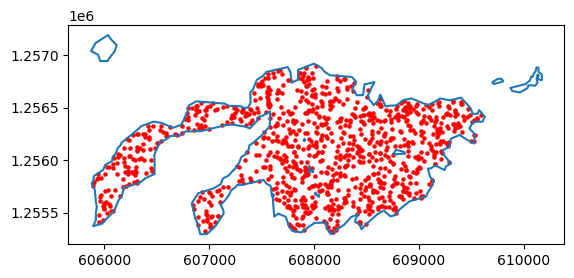

In [274]:
## Alt plot
%matplotlib inline
fig, ax = plt.subplots()
lakes_gdf.boundary.plot(ax=ax)
rand_pts_gs.plot(c='red', ax=ax, markersize=5)

In [235]:
pts_gdf = gpd.GeoDataFrame(geometry = [Point(pt) for pt in rand_pts], crs=lakes_gdf.crs)
m.add_gdf(lakes_gdf)
m.add_gdf(pts_gdf)
m

Map(center=[51.085834663838725, -87.27683764763927], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [237]:
feature.boundary.distance(rand_pts_geom[20]) #, align=False)
# help(feature.distance)
# gpd.GeoSeries.distance
# lakes_gdf.loc[0:1, 'geometry'].boundary.distance(rand_pts_gs[1:5], align=False)
type(lakes_gdf.loc[0:1, 'geometry'])
type(lakes_gdf.loc[1, 'geometry'])
type(lakes_gdf.iloc[1, :])
type(lakes_gdf.iloc[0:1, :])
# lakes_gdf.loc[1, 'geometry']
rand_pts_gs.distance(feature.boundary) # <<<< THIS IS IT!
rand_pts_gs.distance(feature.boundary).mean()

134.22572681821518

## Run on real data!

Variables:
```
Index(['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Lake_area', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat',
       'Reference', 'Site Name', 'Location', 'latitude', 'longitude',
       'Study Year', 'area (ha)', 'ch4 (umol/', 'co2 (umol/', 'temp (C)',
       'temp (esti', 'atm. co2', 'atm. ch4', 'mean_bound', 'geometry'],
      dtype='object')'
      ```

In [312]:
## Function
def calcMeanBoundDist(gdf):
    '''Calculate the mean distance to polygon boundary for an arbitrary number of random points inside.'''
    for i, feature in tqdm(enumerate(gdf.loc[:, 'geometry'])): # 0:4
        rand_pts = pp.random.poisson(feature, size=1000)
        rand_pts_gs = gpd.GeoSeries([Point(pt) for pt in rand_pts], crs=gdf.crs)
        gdf.loc[i, 'mean_bound_dist'] = rand_pts_gs.distance(feature.boundary).mean()
    return gdf

In [ ]:
def annotate_r2(data, x, y, log=False):
    ''' Add r2 and p.  x and y are var names.'''
    data=data.dropna(subset=[x,y])
    if log==True:
        r, p = pearsonr(np.log10(data[x]), np.log10(data[y]))
    else:
        r, p = pearsonr(data[x], data[y])
    return f'$r^2$={r**2:.2f}, p={p:.2f}'

In [332]:
## I/O
# pth = '/mnt/g/Ch4/misc/HL_w_HR16.shp'
pth = '/mnt/f/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/out/HL_Norway.shp'
pth_out = pth.replace('.shp','_md.shp')
# proj = '+proj=laea +lon_0=-13 +lat_0=18.5 +datum=WGS84 +units=m +no_defs' # from https://projectionwizard.org/#
proj = '+proj=tcea +lon_0=13.7109375 +datum=WGS84 +units=m +no_defs' # for Norway

In [333]:
## Compute mean shoreline distance (only need to run once)
## Load
lakes_gdf = gpd.read_file(pth).to_crs(proj) # TODO: which projection for global equal area

## Compute
lakes_gdf_out = calcMeanBoundDist(lakes_gdf)

## Write out
lakes_gdf_out.to_file(pth_out)

19226it [34:18,  9.34it/s]


In [334]:
## Plotting params
sns.set_theme('notebook')
sns.set_style('ticks')


## Norway plots

In [510]:
## I/O
lakes_gdf_out = gpd.read_file('/mnt/f/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/out/HL_Norway_md.shp')

Text(0.7, 0.05, '$r^2$=0.71, p=0.00')

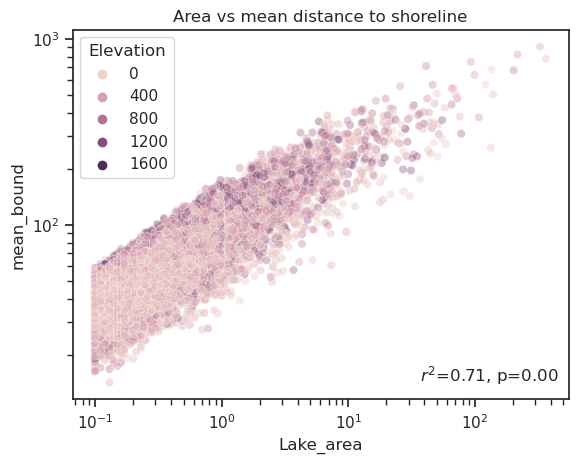

In [511]:
## View and plot relationship to area
# sns.scatterplot(lakes_gdf_out, x='area (ha)', y = 'mean_bound') # HR16
x='Lake_area'
y='mean_bound'
g = sns.scatterplot(lakes_gdf_out, x=x, y =y, hue='Elevation', alpha=0.4) # hue_norm=LogNorm(),
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Area vs mean distance to shoreline')
g.annotate(annotate_r2(lakes_gdf_out, x, y, log=True), xy=(0.7,0.05), xycoords='axes fraction')

Text(0.5, 1.0, 'SDI vs mean distance to shoreline')

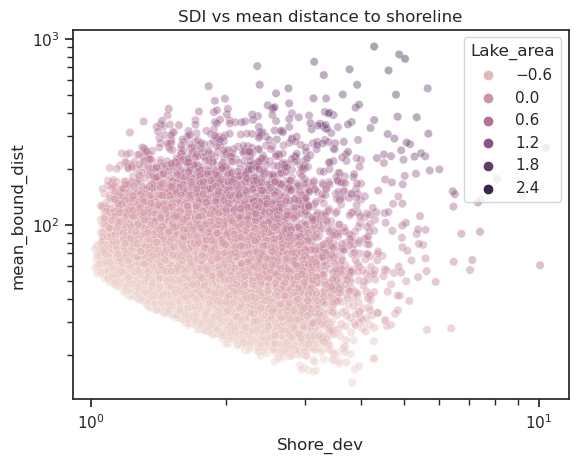

In [350]:
## View and plot relationship to area
from matplotlib.colors import PowerNorm
# sns.scatterplot(lakes_gdf_out, x='area (ha)', y = 'mean_bound') # HR16
sns.scatterplot(lakes_gdf_out, x='Shore_dev', y = 'mean_bound', alpha=0.4, hue=np.log10(lakes_gdf_out.Lake_area)) #, hue_norm=PowerNorm(lakes_gdf_out.Lake_area))
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('SDI vs mean distance to shoreline')

## HR16 plots

In [357]:
## I/O
lakes_gdf_out = gpd.read_file('/mnt/g/Ch4/misc/HL_w_HR16_md.shp')

Text(0.7, 0.05, '$r^2$=0.04, p=0.31')

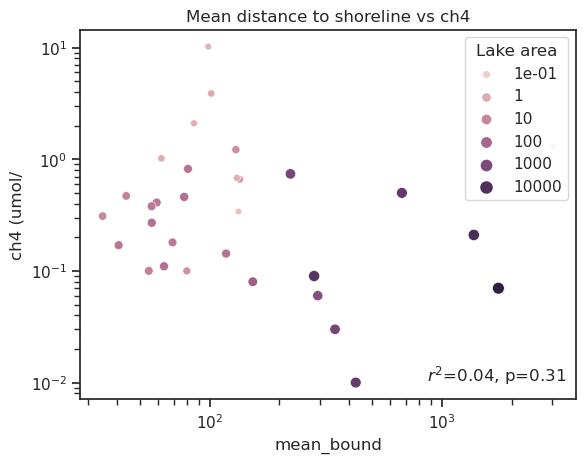

In [492]:
## View and plot relationship to ch4
x= 'mean_bound'
y = 'ch4 (umol/'
g = sns.scatterplot(lakes_gdf_out, x=x, y = y, hue="area (ha)", hue_norm=LogNorm(), size="area (ha)", size_norm=LogNorm())
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Mean distance to shoreline vs ch4')
g.legend(loc='best', title='Lake area')
g.annotate(annotate_r2(lakes_gdf_out, x, y, log=True), xy=(0.7,0.05), xycoords='axes fraction')

Text(0.7, 0.05, '$r^2$=0.00, p=1.00')

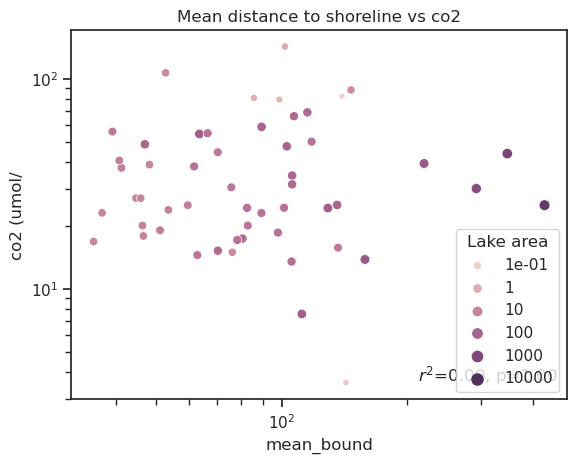

In [484]:
## View and plot relationship to co2
x= 'mean_bound'
y = 'co2 (umol/'
g = sns.scatterplot(lakes_gdf_out, x=x, y = y, hue="area (ha)", hue_norm=LogNorm(), size="area (ha)", size_norm=LogNorm())
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Mean distance to shoreline vs co2')
g.legend(loc='best', title='Lake area')
g.annotate(annotate_r2(lakes_gdf_out, x, y, log=True), xy=(0.7,0.05), xycoords='axes fraction')

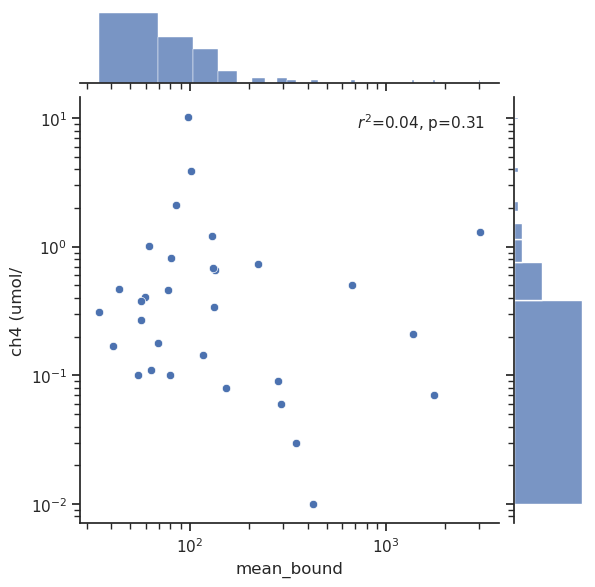

In [463]:
## Jointplot with same data
x= 'mean_bound'
y = 'ch4 (umol/'
g = sns.jointplot(lakes_gdf_out, x=x, y=y) #, stat_func=pearsonr) #  kind="reg", , hue="area (ha)"
plt.xscale('log'), plt.yscale('log')
# g.annotate(annotate_r2(x='mean_bound', y = 'ch4 (umol/', data=lakes_gdf_out), xy=(0.7,0.9), xycoords='axes fraction')
dummy, = g.ax_joint.plot([], [], linestyle="", alpha=0) # here graph is not a ax but a joint grid, so we access the axis through ax_joint method
g.ax_joint.legend([dummy],[annotate_r2(lakes_gdf_out, x, y, log=True)], frameon=False)

Text(0.7, 0.05, '$r^2$=0.41, p=0.00')

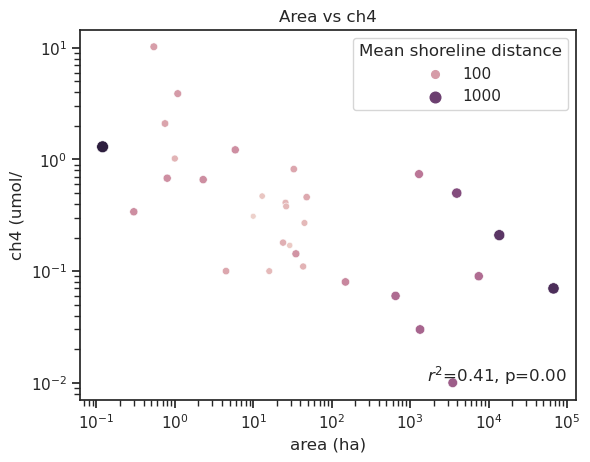

In [483]:
## View and plot relationship to ch4
x= 'area (ha)'
y = 'ch4 (umol/'
g = sns.scatterplot(lakes_gdf_out, x=x, y = y, hue="mean_bound", hue_norm=LogNorm(), size="mean_bound", size_norm=LogNorm())
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Area vs ch4')
g.legend(loc='best', title='Mean shoreline distance')
g.annotate(annotate_r2(lakes_gdf_out, x, y, log=True), xy=(0.7,0.05), xycoords='axes fraction')

## Generic/test plots

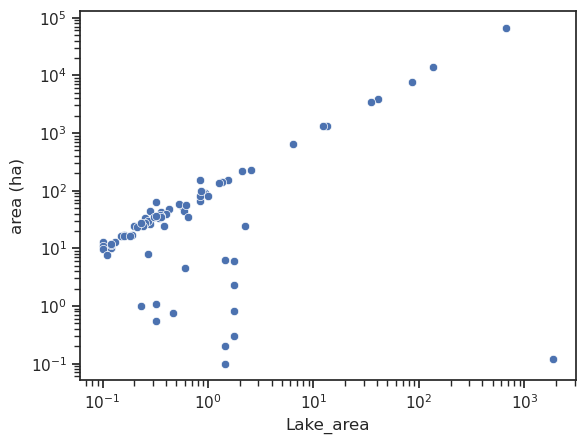

In [305]:
## View and plot areas from different ds
sns.scatterplot(lakes_gdf_out, x='Lake_area', y = 'area (ha)')
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Hydrolakes vs HR16 areas')

Text(0.5, 1.0, 'Hydrolakes vs map projection area')

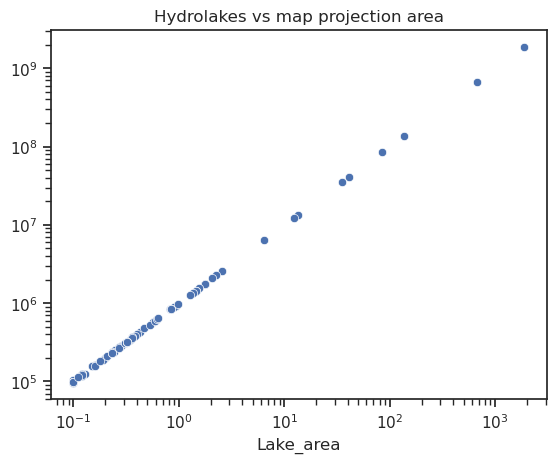

In [307]:
## View and plot areas from different ds
sns.scatterplot(lakes_gdf_out, x='Lake_area', y = lakes_gdf_out.area)
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Hydrolakes vs map projection area')

## Testing examples

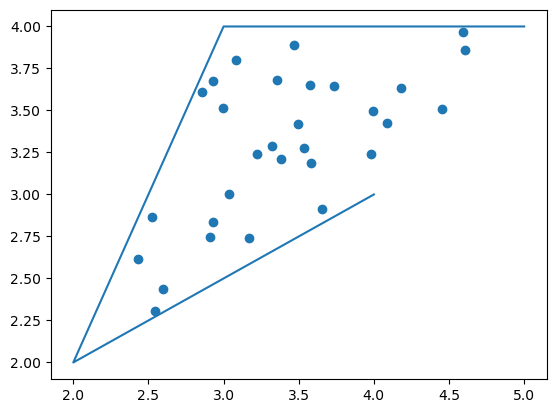

In [67]:
## Pointpats random points generation
## https://stackoverflow.com/questions/56393503/how-can-i-generate-random-coordinates-inside-a-polygon

 
# Coordinates of polygon edges
coords = [[5,4],[3,4], [2,2],[4,3]]
point1 = Point([3,3])
point2 = Point([0,4])
pgon = Polygon(coords)

# Generates 5 points inside polygon
random_pts = pp.random.poisson(pgon, size=30)

## View
coords_np = np.array(coords)
plt.plot(coords_np[:,0], coords_np[:,1])
plt.scatter(random_pts[:,0], random_pts[:,1])

In [68]:
## Calc distance from point to poly
from libpysal.cg import get_polygon_point_dist
get_polygon_point_dist(pgon, point1)

AttributeError: 'Polygon' object has no attribute 'bounding_box'

In [117]:
dir(pointpats)

['HexagonM',
 'PointPattern',
 'PointProcess',
 'PoissonClusterPointProcess',
 'PoissonPointProcess',
 'QStatistic',
 'RectangleM',
 'SpaceTimeEvents',
 'Window',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_circle',
 '_deprecated_distance_statistics',
 'as_window',
 'centrography',
 'distance_statistics',
 'dtot',
 'ellipse',
 'euclidean_median',
 'f',
 'f_test',
 'g',
 'g_test',
 'geometry',
 'hull',
 'j',
 'j_test',
 'jacquez',
 'k',
 'k_test',
 'knox',
 'l',
 'l_test',
 'manhattan_median',
 'mantel',
 'mbr',
 'mean_center',
 'minimum_bounding_rectangle',
 'minimum_rotated_rectangle',
 'modified_knox',
 'pointpattern',
 'poly_from_bbox',
 'process',
 'quadrat_statistics',
 'random',
 'skyum',
 'spacetime',
 'std_distance',
 'to_ccf',
 'util',
 'weighted_mean_center',
 'window']